In [ ]:
import os
import pandas as pd
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch

# Path to the folder with images and the CSV file
image_folder = '/kaggle/input/rococo/Rococo/Rococo'
csv_file = '/kaggle/input/rococo/Rococo.csv'

# Load CSV file
df = pd.read_csv(csv_file)

# Image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.image_folder, row['filename'])
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        # Get text (e.g., genre or description)
        text = ' '.join(row['genre'])
        
        return image, text

# Create dataset and dataloader
dataset = CustomDataset(df, image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Load the model for fine-tuning (Stable Diffusion)
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)

# Extract model components
unet = pipe.unet
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer
vae = pipe.vae

# Move models to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)
text_encoder.to(device)
vae.to(device)

# Define training parameters
epochs = 3
learning_rate = 5e-6

# Optimizers
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
text_optimizer = torch.optim.AdamW(text_encoder.parameters(), lr=learning_rate)

# Main training loop
accumulation_steps = 4
for epoch in range(epochs):
    unet.train()
    text_encoder.train()
    optimizer.zero_grad()
    for step, batch in enumerate(dataloader):
        images, texts = batch
        images = images.to(device)

        # Convert text to embeddings using the CLIP model
        text_input = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
        text_embeddings = text_encoder(**text_input).last_hidden_state
        
        # Encode images to latents using VAE
        latents = vae.encode(images).latent_dist.sample()
        
        # Generate timesteps for diffusion
        timesteps = torch.randint(0, 100, (latents.shape[0],), device=device).long()

        # Add noise to the latents
        noise = torch.randn_like(latents).to(device)
        latents = latents + noise
        
        # Predict latents using UNet
        output = unet(latents, timestep=timesteps, encoder_hidden_states=text_embeddings)
        pred_latents = output.sample
        loss = torch.nn.functional.mse_loss(pred_latents, latents)

        # Gradient accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # Update parameters after accumulation
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{epochs}, Step {step+1}, Loss: {loss.item()}")

# Save the final model
pipe.save_pretrained("/kaggle/working/final_model")


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1743187301.440798      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230



Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]


Fetching 16 files:   6%|▋         | 1/16 [00:00<00:03,  4.41it/s]


Fetching 16 files:  25%|██▌       | 4/16 [00:06<00:20,  1.71s/it]


Fetching 16 files:  88%|████████▊ | 14/16 [00:16<00:02,  1.19s/it]


Fetching 16 files: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:03,  1.89it/s]


Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  3.16it/s]


Loading pipeline components...:  57%|█████▋    | 4/7 [00:01<00:00,  3.68it/s]


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  7.06it/s]


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.29it/s]

Epoch 1/3, Step 1, Loss: 2.7364087104797363


Epoch 1/3, Step 2, Loss: 2.8240554332733154


Epoch 1/3, Step 3, Loss: 2.646841049194336


Epoch 1/3, Step 4, Loss: 2.4499869346618652


Epoch 1/3, Step 5, Loss: 2.419724225997925


Epoch 1/3, Step 6, Loss: 2.9754648208618164


Epoch 1/3, Step 7, Loss: 3.118164539337158


Epoch 1/3, Step 8, Loss: 2.5734951496124268


Epoch 1/3, Step 9, Loss: 2.1961541175842285


Epoch 1/3, Step 10, Loss: 2.468581199645996


Epoch 1/3, Step 11, Loss: 2.8205389976501465


Epoch 1/3, Step 12, Loss: 2.41961407661438


Epoch 1/3, Step 13, Loss: 2.521918296813965


Epoch 1/3, Step 14, Loss: 3.3619089126586914


Epoch 1/3, Step 15, Loss: 2.918956756591797


Epoch 1/3, Step 16, Loss: 2.8310153484344482


Epoch 1/3, Step 17, Loss: 2.4607040882110596


Epoch 1/3, Step 18, Loss: 2.9031002521514893


Epoch 1/3, Step 19, Loss: 2.328791379928589


Epoch 1/3, Step 20, Loss: 2.6405727863311768


Epoch 1/3, Step 21, Loss: 2.6785175800323486


Epoch 1/3, Step 22, Loss: 2.625608205795288


Epoch 1/3, Step 23, Loss: 2.5519888401031494


Epoch 1/3, Step 24, Loss: 3.3485982418060303


Epoch 1/3, Step 25, Loss: 2.5518887042999268


Epoch 1/3, Step 26, Loss: 2.2370195388793945


Epoch 1/3, Step 27, Loss: 2.5887255668640137


Epoch 1/3, Step 28, Loss: 2.9883205890655518


Epoch 1/3, Step 29, Loss: 2.25372052192688


Epoch 1/3, Step 30, Loss: 2.230952501296997


Epoch 1/3, Step 31, Loss: 2.9685311317443848


Epoch 1/3, Step 32, Loss: 2.6624832153320312


Epoch 1/3, Step 33, Loss: 2.405172824859619


Epoch 1/3, Step 34, Loss: 2.5489842891693115


Epoch 1/3, Step 35, Loss: 2.858032703399658


Epoch 1/3, Step 36, Loss: 2.804513692855835


Epoch 1/3, Step 37, Loss: 2.331789016723633


Epoch 1/3, Step 38, Loss: 2.945797920227051


Epoch 1/3, Step 39, Loss: 2.3840625286102295


Epoch 1/3, Step 40, Loss: 2.6119956970214844


Epoch 1/3, Step 41, Loss: 3.477353811264038


Epoch 1/3, Step 42, Loss: 2.108041286468506


Epoch 1/3, Step 43, Loss: 3.124770164489746


Epoch 1/3, Step 44, Loss: 2.8319458961486816


Epoch 1/3, Step 45, Loss: 2.3028323650360107


Epoch 1/3, Step 46, Loss: 2.2622551918029785


Epoch 1/3, Step 47, Loss: 3.3332359790802


Epoch 1/3, Step 48, Loss: 2.4588944911956787


Epoch 1/3, Step 49, Loss: 2.35445499420166


Epoch 1/3, Step 50, Loss: 3.0088751316070557


Epoch 1/3, Step 51, Loss: 2.3861680030822754


Epoch 1/3, Step 52, Loss: 2.501664638519287


Epoch 1/3, Step 53, Loss: 2.317627191543579


Epoch 1/3, Step 54, Loss: 2.6859991550445557


Epoch 1/3, Step 55, Loss: 2.237527370452881


Epoch 1/3, Step 56, Loss: 2.0726051330566406


Epoch 1/3, Step 57, Loss: 2.72574520111084


Epoch 1/3, Step 58, Loss: 2.241921901702881


Epoch 1/3, Step 59, Loss: 3.0867531299591064


Epoch 1/3, Step 60, Loss: 2.432197093963623


Epoch 1/3, Step 61, Loss: 1.873969554901123


Epoch 1/3, Step 62, Loss: 2.773667335510254


Epoch 1/3, Step 63, Loss: 2.1506879329681396


Epoch 1/3, Step 64, Loss: 2.1662709712982178


Epoch 1/3, Step 65, Loss: 2.3737199306488037


Epoch 1/3, Step 66, Loss: 2.82719087600708


Epoch 1/3, Step 67, Loss: 3.1107537746429443


Epoch 1/3, Step 68, Loss: 2.7984743118286133


Epoch 1/3, Step 69, Loss: 2.4390158653259277


Epoch 1/3, Step 70, Loss: 3.0384998321533203


Epoch 1/3, Step 71, Loss: 2.493380308151245


Epoch 1/3, Step 72, Loss: 2.609628915786743


Epoch 1/3, Step 73, Loss: 2.2447991371154785


Epoch 1/3, Step 74, Loss: 2.840798854827881


Epoch 1/3, Step 75, Loss: 2.6305108070373535


Epoch 1/3, Step 76, Loss: 3.086026191711426


Epoch 1/3, Step 77, Loss: 2.228085517883301


Epoch 1/3, Step 78, Loss: 2.387064218521118


Epoch 1/3, Step 79, Loss: 2.1390373706817627


Epoch 1/3, Step 80, Loss: 2.4302921295166016


Epoch 1/3, Step 81, Loss: 2.0204110145568848


Epoch 1/3, Step 82, Loss: 2.9593565464019775


Epoch 1/3, Step 83, Loss: 2.2741007804870605


Epoch 1/3, Step 84, Loss: 2.5631868839263916


Epoch 1/3, Step 85, Loss: 2.5135855674743652


Epoch 1/3, Step 86, Loss: 2.1808199882507324


Epoch 1/3, Step 87, Loss: 2.819427013397217


Epoch 1/3, Step 88, Loss: 2.746553659439087


Epoch 1/3, Step 89, Loss: 2.0828216075897217


Epoch 1/3, Step 90, Loss: 2.793128728866577


Epoch 1/3, Step 91, Loss: 2.1127607822418213


Epoch 1/3, Step 92, Loss: 2.1324830055236816


Epoch 1/3, Step 93, Loss: 2.193477153778076


Epoch 1/3, Step 94, Loss: 2.482701063156128


Epoch 1/3, Step 95, Loss: 2.7387375831604004


Epoch 1/3, Step 96, Loss: 2.227470874786377


Epoch 1/3, Step 97, Loss: 2.940915584564209


Epoch 1/3, Step 98, Loss: 2.464867115020752


Epoch 1/3, Step 99, Loss: 2.220468521118164


Epoch 1/3, Step 100, Loss: 2.8232786655426025


Epoch 1/3, Step 101, Loss: 2.4167890548706055


Epoch 1/3, Step 102, Loss: 2.1547560691833496


Epoch 1/3, Step 103, Loss: 3.1907641887664795


Epoch 1/3, Step 104, Loss: 2.2641494274139404


Epoch 1/3, Step 105, Loss: 2.503727674484253


Epoch 1/3, Step 106, Loss: 2.330294609069824


Epoch 1/3, Step 107, Loss: 2.766230583190918


Epoch 1/3, Step 108, Loss: 2.5724446773529053


Epoch 1/3, Step 109, Loss: 2.1226329803466797


Epoch 1/3, Step 110, Loss: 2.4679408073425293


Epoch 1/3, Step 111, Loss: 2.4253692626953125


Epoch 1/3, Step 112, Loss: 2.8157553672790527


Epoch 1/3, Step 113, Loss: 2.704998016357422


Epoch 1/3, Step 114, Loss: 2.6454663276672363


Epoch 1/3, Step 115, Loss: 2.7032530307769775


Epoch 1/3, Step 116, Loss: 2.721007823944092


Epoch 1/3, Step 117, Loss: 2.2835609912872314


Epoch 1/3, Step 118, Loss: 2.060332775115967


Epoch 1/3, Step 119, Loss: 2.139402151107788


Epoch 1/3, Step 120, Loss: 2.2366535663604736


Epoch 1/3, Step 121, Loss: 2.5874829292297363


Epoch 1/3, Step 122, Loss: 2.1697912216186523


Epoch 1/3, Step 123, Loss: 2.269787311553955


Epoch 1/3, Step 124, Loss: 2.0333218574523926


Epoch 1/3, Step 125, Loss: 1.9973933696746826


Epoch 1/3, Step 126, Loss: 1.901778221130371


Epoch 1/3, Step 127, Loss: 1.738193154335022


Epoch 1/3, Step 128, Loss: 2.2010655403137207


Epoch 1/3, Step 129, Loss: 2.0597891807556152


Epoch 1/3, Step 130, Loss: 2.7786197662353516


Epoch 1/3, Step 131, Loss: 1.9905351400375366


Epoch 1/3, Step 132, Loss: 2.6142358779907227


Epoch 1/3, Step 133, Loss: 2.903934955596924


Epoch 1/3, Step 134, Loss: 2.641836166381836


Epoch 1/3, Step 135, Loss: 2.022494316101074


Epoch 1/3, Step 136, Loss: 2.184842109680176


Epoch 1/3, Step 137, Loss: 2.4959845542907715


Epoch 1/3, Step 138, Loss: 2.4587323665618896


Epoch 1/3, Step 139, Loss: 2.294074058532715


Epoch 1/3, Step 140, Loss: 2.3928823471069336


Epoch 1/3, Step 141, Loss: 2.313201665878296


Epoch 1/3, Step 142, Loss: 2.302907943725586


Epoch 1/3, Step 143, Loss: 1.7627453804016113


Epoch 1/3, Step 144, Loss: 2.284937620162964


Epoch 1/3, Step 145, Loss: 3.1022913455963135


Epoch 1/3, Step 146, Loss: 2.1299006938934326


Epoch 1/3, Step 147, Loss: 1.958242654800415


Epoch 1/3, Step 148, Loss: 2.06881046295166


Epoch 1/3, Step 149, Loss: 2.532332420349121


Epoch 1/3, Step 150, Loss: 2.8617870807647705


Epoch 1/3, Step 151, Loss: 2.303295135498047


Epoch 1/3, Step 152, Loss: 2.4197638034820557


Epoch 1/3, Step 153, Loss: 2.2952396869659424


Epoch 1/3, Step 154, Loss: 2.4658615589141846


Epoch 1/3, Step 155, Loss: 3.07970929145813


Epoch 1/3, Step 156, Loss: 2.250763177871704


Epoch 1/3, Step 157, Loss: 2.830179452896118


Epoch 1/3, Step 158, Loss: 2.635319948196411


Epoch 1/3, Step 159, Loss: 3.1869771480560303


Epoch 1/3, Step 160, Loss: 2.099658727645874


Epoch 1/3, Step 161, Loss: 2.620579481124878


Epoch 1/3, Step 162, Loss: 2.5425922870635986


Epoch 1/3, Step 163, Loss: 2.375105381011963


Epoch 1/3, Step 164, Loss: 2.333411455154419


Epoch 1/3, Step 165, Loss: 2.198087453842163


Epoch 1/3, Step 166, Loss: 2.2878403663635254


Epoch 1/3, Step 167, Loss: 1.724524736404419


Epoch 1/3, Step 168, Loss: 2.568274736404419


Epoch 1/3, Step 169, Loss: 2.124997138977051


Epoch 1/3, Step 170, Loss: 2.0887794494628906


Epoch 1/3, Step 171, Loss: 1.9241656064987183


Epoch 1/3, Step 172, Loss: 2.5222506523132324


Epoch 1/3, Step 173, Loss: 2.275052070617676


Epoch 1/3, Step 174, Loss: 2.0645625591278076


Epoch 1/3, Step 175, Loss: 2.558852434158325


Epoch 1/3, Step 176, Loss: 2.296154737472534


Epoch 1/3, Step 177, Loss: 2.0502769947052


Epoch 1/3, Step 178, Loss: 2.7220301628112793


Epoch 1/3, Step 179, Loss: 2.138787031173706


Epoch 1/3, Step 180, Loss: 2.6259608268737793


Epoch 1/3, Step 181, Loss: 2.520552158355713


Epoch 1/3, Step 182, Loss: 2.3259470462799072


Epoch 1/3, Step 183, Loss: 2.3804783821105957


Epoch 1/3, Step 184, Loss: 1.8188509941101074


Epoch 1/3, Step 185, Loss: 2.188965320587158


Epoch 1/3, Step 186, Loss: 1.9687371253967285


Epoch 1/3, Step 187, Loss: 2.4222898483276367


Epoch 1/3, Step 188, Loss: 2.485175371170044


Epoch 1/3, Step 189, Loss: 2.4041998386383057


Epoch 1/3, Step 190, Loss: 2.320195198059082


Epoch 1/3, Step 191, Loss: 2.136563777923584


Epoch 1/3, Step 192, Loss: 2.3883447647094727


Epoch 1/3, Step 193, Loss: 2.5827183723449707


Epoch 1/3, Step 194, Loss: 2.1103403568267822


Epoch 1/3, Step 195, Loss: 2.338191509246826


Epoch 1/3, Step 196, Loss: 1.9380543231964111


Epoch 1/3, Step 197, Loss: 2.0023434162139893


Epoch 1/3, Step 198, Loss: 2.657198667526245


Epoch 1/3, Step 199, Loss: 3.10723876953125


Epoch 1/3, Step 200, Loss: 1.9234068393707275


Epoch 1/3, Step 201, Loss: 2.3190596103668213


Epoch 1/3, Step 202, Loss: 2.1233389377593994


Epoch 1/3, Step 203, Loss: 2.2776572704315186


Epoch 1/3, Step 204, Loss: 2.234954833984375


Epoch 1/3, Step 205, Loss: 2.8952488899230957


Epoch 1/3, Step 206, Loss: 1.899380087852478


Epoch 1/3, Step 207, Loss: 1.9430149793624878


Epoch 1/3, Step 208, Loss: 1.8736915588378906


Epoch 1/3, Step 209, Loss: 2.1803691387176514


Epoch 1/3, Step 210, Loss: 2.175025463104248


Epoch 1/3, Step 211, Loss: 2.9164485931396484


Epoch 1/3, Step 212, Loss: 2.5036404132843018


Epoch 1/3, Step 213, Loss: 1.9457437992095947


Epoch 1/3, Step 214, Loss: 2.1804237365722656


Epoch 1/3, Step 215, Loss: 1.8801493644714355


Epoch 1/3, Step 216, Loss: 2.1203014850616455


Epoch 1/3, Step 217, Loss: 2.249250650405884


Epoch 1/3, Step 218, Loss: 2.148676872253418


Epoch 1/3, Step 219, Loss: 2.590000629425049


Epoch 1/3, Step 220, Loss: 2.277939796447754


Epoch 1/3, Step 221, Loss: 2.94183349609375


Epoch 1/3, Step 222, Loss: 1.5111043453216553


Epoch 1/3, Step 223, Loss: 2.2905068397521973


Epoch 1/3, Step 224, Loss: 2.139863967895508


Epoch 1/3, Step 225, Loss: 2.152402877807617


Epoch 1/3, Step 226, Loss: 2.130657911300659


Epoch 1/3, Step 227, Loss: 2.1174798011779785


Epoch 1/3, Step 228, Loss: 2.030047655105591


Epoch 1/3, Step 229, Loss: 2.681758165359497


Epoch 1/3, Step 230, Loss: 1.9360904693603516


Epoch 1/3, Step 231, Loss: 2.554349422454834


Epoch 1/3, Step 232, Loss: 2.0085182189941406


Epoch 1/3, Step 233, Loss: 2.381786823272705


Epoch 1/3, Step 234, Loss: 1.7974534034729004


Epoch 1/3, Step 235, Loss: 1.6550408601760864


Epoch 1/3, Step 236, Loss: 2.7150049209594727


Epoch 1/3, Step 237, Loss: 1.9884318113327026


Epoch 1/3, Step 238, Loss: 2.2520930767059326


Epoch 1/3, Step 239, Loss: 1.55730402469635


Epoch 1/3, Step 240, Loss: 2.3714849948883057


Epoch 1/3, Step 241, Loss: 2.4473700523376465


Epoch 1/3, Step 242, Loss: 2.2079360485076904


Epoch 1/3, Step 243, Loss: 2.1282782554626465


Epoch 1/3, Step 244, Loss: 2.175685405731201


Epoch 1/3, Step 245, Loss: 1.5552040338516235


Epoch 1/3, Step 246, Loss: 1.6389228105545044


Epoch 1/3, Step 247, Loss: 2.54443097114563


Epoch 1/3, Step 248, Loss: 1.7938649654388428


Epoch 1/3, Step 249, Loss: 3.3731586933135986


Epoch 1/3, Step 250, Loss: 2.1965012550354004


Epoch 1/3, Step 251, Loss: 2.1789908409118652


Epoch 1/3, Step 252, Loss: 2.5891342163085938


Epoch 1/3, Step 253, Loss: 2.1752123832702637


Epoch 1/3, Step 254, Loss: 2.6664302349090576


Epoch 1/3, Step 255, Loss: 2.1291966438293457


Epoch 1/3, Step 256, Loss: 3.0192911624908447


Epoch 1/3, Step 257, Loss: 2.135836124420166


Epoch 1/3, Step 258, Loss: 2.1141393184661865


Epoch 1/3, Step 259, Loss: 2.1392383575439453


Epoch 1/3, Step 260, Loss: 2.3581254482269287


Epoch 1/3, Step 261, Loss: 1.9137717485427856


Epoch 2/3, Step 1, Loss: 2.1304543018341064


Epoch 2/3, Step 2, Loss: 1.4705477952957153


Epoch 2/3, Step 3, Loss: 2.7437071800231934


Epoch 2/3, Step 4, Loss: 2.4371402263641357


Epoch 2/3, Step 5, Loss: 2.1813442707061768


Epoch 2/3, Step 6, Loss: 2.0885257720947266


Epoch 2/3, Step 7, Loss: 2.362140417098999


Epoch 2/3, Step 8, Loss: 1.9072695970535278


Epoch 2/3, Step 9, Loss: 2.292428970336914


Epoch 2/3, Step 10, Loss: 2.8683323860168457


Epoch 2/3, Step 11, Loss: 1.6551061868667603


Epoch 2/3, Step 12, Loss: 1.7480456829071045


Epoch 2/3, Step 13, Loss: 2.1944689750671387


Epoch 2/3, Step 14, Loss: 2.7860264778137207


Epoch 2/3, Step 15, Loss: 1.8839524984359741


Epoch 2/3, Step 16, Loss: 2.2449631690979004


Epoch 2/3, Step 17, Loss: 1.968530297279358


Epoch 2/3, Step 18, Loss: 1.9722226858139038


Epoch 2/3, Step 19, Loss: 2.0370535850524902


Epoch 2/3, Step 20, Loss: 2.085970401763916


Epoch 2/3, Step 21, Loss: 1.570631742477417


Epoch 2/3, Step 22, Loss: 1.98123300075531


Epoch 2/3, Step 23, Loss: 2.575378179550171


Epoch 2/3, Step 24, Loss: 2.3821985721588135


Epoch 2/3, Step 25, Loss: 2.013550043106079


Epoch 2/3, Step 26, Loss: 2.060948371887207


Epoch 2/3, Step 27, Loss: 2.287693977355957


Epoch 2/3, Step 28, Loss: 2.1519694328308105


Epoch 2/3, Step 29, Loss: 2.231839895248413


Epoch 2/3, Step 30, Loss: 2.0267109870910645


Epoch 2/3, Step 31, Loss: 1.415268063545227


Epoch 2/3, Step 32, Loss: 1.668956995010376


Epoch 2/3, Step 33, Loss: 2.042085647583008


Epoch 2/3, Step 34, Loss: 2.1246726512908936


Epoch 2/3, Step 35, Loss: 2.090672016143799


Epoch 2/3, Step 36, Loss: 1.89341402053833


Epoch 2/3, Step 37, Loss: 2.230618476867676


Epoch 2/3, Step 38, Loss: 3.9120588302612305


Epoch 2/3, Step 39, Loss: 1.952419400215149


Epoch 2/3, Step 40, Loss: 2.9334664344787598


Epoch 2/3, Step 41, Loss: 1.8838205337524414


Epoch 2/3, Step 42, Loss: 2.2850699424743652


Epoch 2/3, Step 43, Loss: 2.302799940109253


Epoch 2/3, Step 44, Loss: 1.8950241804122925


Epoch 2/3, Step 45, Loss: 2.5147552490234375


Epoch 2/3, Step 46, Loss: 2.3566179275512695


Epoch 2/3, Step 47, Loss: 1.5895942449569702


Epoch 2/3, Step 48, Loss: 2.37328839302063


Epoch 2/3, Step 49, Loss: 1.881168246269226


Epoch 2/3, Step 50, Loss: 2.109218120574951


Epoch 2/3, Step 51, Loss: 2.137465476989746


Epoch 2/3, Step 52, Loss: 2.278153419494629


Epoch 2/3, Step 53, Loss: 1.3796602487564087


Epoch 2/3, Step 54, Loss: 1.982872724533081


Epoch 2/3, Step 55, Loss: 2.85137939453125


Epoch 2/3, Step 56, Loss: 1.7574759721755981


Epoch 2/3, Step 57, Loss: 2.2917683124542236


Epoch 2/3, Step 58, Loss: 1.8671000003814697


Epoch 2/3, Step 59, Loss: 1.974103331565857


Epoch 2/3, Step 60, Loss: 2.3339169025421143


Epoch 2/3, Step 61, Loss: 2.473914861679077


Epoch 2/3, Step 62, Loss: 2.290313720703125


Epoch 2/3, Step 63, Loss: 1.9983391761779785


Epoch 2/3, Step 64, Loss: 2.5384647846221924


Epoch 2/3, Step 65, Loss: 2.199957847595215


Epoch 2/3, Step 66, Loss: 2.1599864959716797


Epoch 2/3, Step 67, Loss: 2.0610742568969727


Epoch 2/3, Step 68, Loss: 2.489351749420166


Epoch 2/3, Step 69, Loss: 2.1289222240448


Epoch 2/3, Step 70, Loss: 2.034327268600464


Epoch 2/3, Step 71, Loss: 1.6492174863815308


Epoch 2/3, Step 72, Loss: 2.3168797492980957


Epoch 2/3, Step 73, Loss: 1.8769632577896118


Epoch 2/3, Step 74, Loss: 1.8426077365875244


Epoch 2/3, Step 75, Loss: 2.1459131240844727


Epoch 2/3, Step 76, Loss: 2.006903886795044


Epoch 2/3, Step 77, Loss: 2.0972132682800293


Epoch 2/3, Step 78, Loss: 2.1701855659484863


Epoch 2/3, Step 79, Loss: 1.7984193563461304


Epoch 2/3, Step 80, Loss: 2.1707146167755127


Epoch 2/3, Step 81, Loss: 2.0564770698547363


Epoch 2/3, Step 82, Loss: 2.3578450679779053


Epoch 2/3, Step 83, Loss: 1.8062678575515747


Epoch 2/3, Step 84, Loss: 1.7572765350341797


Epoch 2/3, Step 85, Loss: 2.0759360790252686


Epoch 2/3, Step 86, Loss: 2.374906301498413


Epoch 2/3, Step 87, Loss: 2.1160929203033447


Epoch 2/3, Step 88, Loss: 2.313338279724121


Epoch 2/3, Step 89, Loss: 2.591895580291748


Epoch 2/3, Step 90, Loss: 2.375943183898926


Epoch 2/3, Step 91, Loss: 2.2119390964508057


Epoch 2/3, Step 92, Loss: 2.0117368698120117


Epoch 2/3, Step 93, Loss: 2.738823175430298


Epoch 2/3, Step 94, Loss: 1.7527713775634766


Epoch 2/3, Step 95, Loss: 1.9009078741073608


Epoch 2/3, Step 96, Loss: 2.3614776134490967


Epoch 2/3, Step 97, Loss: 2.3864049911499023


Epoch 2/3, Step 98, Loss: 2.1999869346618652


Epoch 2/3, Step 99, Loss: 1.9683406352996826


Epoch 2/3, Step 100, Loss: 1.8080370426177979


Epoch 2/3, Step 101, Loss: 1.9775274991989136


Epoch 2/3, Step 102, Loss: 1.6080811023712158


Epoch 2/3, Step 103, Loss: 2.218261241912842


Epoch 2/3, Step 104, Loss: 1.8736941814422607


Epoch 2/3, Step 105, Loss: 2.1167750358581543


Epoch 2/3, Step 106, Loss: 2.5669918060302734


Epoch 2/3, Step 107, Loss: 1.9425591230392456


Epoch 2/3, Step 108, Loss: 2.376000165939331


Epoch 2/3, Step 109, Loss: 1.9047791957855225


Epoch 2/3, Step 110, Loss: 1.6403281688690186


Epoch 2/3, Step 111, Loss: 2.520759105682373


Epoch 2/3, Step 112, Loss: 2.140245199203491


Epoch 2/3, Step 113, Loss: 1.9202983379364014


Epoch 2/3, Step 114, Loss: 2.1531171798706055


Epoch 2/3, Step 115, Loss: 2.1929259300231934


Epoch 2/3, Step 116, Loss: 2.554015636444092


Epoch 2/3, Step 117, Loss: 2.1733956336975098


Epoch 2/3, Step 118, Loss: 1.9014235734939575


Epoch 2/3, Step 119, Loss: 1.8511261940002441


Epoch 2/3, Step 120, Loss: 2.049834966659546


Epoch 2/3, Step 121, Loss: 1.7870975732803345


Epoch 2/3, Step 122, Loss: 2.083561897277832


Epoch 2/3, Step 123, Loss: 2.1286816596984863


Epoch 2/3, Step 124, Loss: 1.9122340679168701


Epoch 2/3, Step 125, Loss: 1.977455735206604


Epoch 2/3, Step 126, Loss: 1.6007912158966064


Epoch 2/3, Step 127, Loss: 1.8899049758911133


Epoch 2/3, Step 128, Loss: 2.291635274887085


Epoch 2/3, Step 129, Loss: 1.9456883668899536


Epoch 2/3, Step 130, Loss: 2.1851089000701904


Epoch 2/3, Step 131, Loss: 2.3492069244384766


Epoch 2/3, Step 132, Loss: 1.7821893692016602


Epoch 2/3, Step 133, Loss: 2.6492178440093994


Epoch 2/3, Step 134, Loss: 2.43570613861084


Epoch 2/3, Step 135, Loss: 1.9551489353179932


Epoch 2/3, Step 136, Loss: 1.86838698387146


Epoch 2/3, Step 137, Loss: 2.321230888366699


Epoch 2/3, Step 138, Loss: 1.9821611642837524


Epoch 2/3, Step 139, Loss: 2.187467336654663


Epoch 2/3, Step 140, Loss: 1.9786195755004883


Epoch 2/3, Step 141, Loss: 2.092885732650757


Epoch 2/3, Step 142, Loss: 2.7659590244293213


Epoch 2/3, Step 143, Loss: 2.0686113834381104


Epoch 2/3, Step 144, Loss: 1.9892334938049316


Epoch 2/3, Step 145, Loss: 1.7065703868865967


Epoch 2/3, Step 146, Loss: 2.023608446121216


Epoch 2/3, Step 147, Loss: 2.0981757640838623


Epoch 2/3, Step 148, Loss: 1.6878623962402344


Epoch 2/3, Step 149, Loss: 2.3480148315429688


Epoch 2/3, Step 150, Loss: 1.6081783771514893


Epoch 2/3, Step 151, Loss: 2.1415183544158936


Epoch 2/3, Step 152, Loss: 2.784416675567627


Epoch 2/3, Step 153, Loss: 1.7062944173812866


Epoch 2/3, Step 154, Loss: 2.090034008026123


Epoch 2/3, Step 155, Loss: 2.0586602687835693


Epoch 2/3, Step 156, Loss: 1.7764893770217896


Epoch 2/3, Step 157, Loss: 1.6237115859985352


Epoch 2/3, Step 158, Loss: 2.175617218017578


Epoch 2/3, Step 159, Loss: 2.1924331188201904


Epoch 2/3, Step 160, Loss: 2.27860426902771


Epoch 2/3, Step 161, Loss: 1.7146193981170654


Epoch 2/3, Step 162, Loss: 1.6859922409057617


Epoch 2/3, Step 163, Loss: 1.9733895063400269


Epoch 2/3, Step 164, Loss: 1.7671520709991455


Epoch 2/3, Step 165, Loss: 2.2093687057495117


Epoch 2/3, Step 166, Loss: 1.9697716236114502


Epoch 2/3, Step 167, Loss: 2.206251621246338


Epoch 2/3, Step 168, Loss: 1.8850440979003906


Epoch 2/3, Step 169, Loss: 2.3236427307128906


Epoch 2/3, Step 170, Loss: 2.2034237384796143


Epoch 2/3, Step 171, Loss: 2.0460305213928223


Epoch 2/3, Step 172, Loss: 2.4996588230133057


Epoch 2/3, Step 173, Loss: 2.0594687461853027


Epoch 2/3, Step 174, Loss: 1.9549850225448608


Epoch 2/3, Step 175, Loss: 2.3954017162323


Epoch 2/3, Step 176, Loss: 2.416738510131836


Epoch 2/3, Step 177, Loss: 2.1585562229156494


Epoch 2/3, Step 178, Loss: 1.6834105253219604


Epoch 2/3, Step 179, Loss: 1.98993718624115


Epoch 2/3, Step 180, Loss: 2.40122127532959


Epoch 2/3, Step 181, Loss: 2.735265016555786


Epoch 2/3, Step 182, Loss: 1.6575477123260498


Epoch 2/3, Step 183, Loss: 1.952620267868042


Epoch 2/3, Step 184, Loss: 1.9028356075286865


Epoch 2/3, Step 185, Loss: 1.792762279510498


Epoch 2/3, Step 186, Loss: 1.480785846710205


Epoch 2/3, Step 187, Loss: 2.1516902446746826


Epoch 2/3, Step 188, Loss: 1.9045374393463135


Epoch 2/3, Step 189, Loss: 2.1903679370880127


Epoch 2/3, Step 190, Loss: 2.1901657581329346


Epoch 2/3, Step 191, Loss: 2.5949034690856934


Epoch 2/3, Step 192, Loss: 1.7929120063781738


Epoch 2/3, Step 193, Loss: 2.708331346511841


Epoch 2/3, Step 194, Loss: 2.6313657760620117


Epoch 2/3, Step 195, Loss: 2.266758918762207


Epoch 2/3, Step 196, Loss: 2.141986608505249


Epoch 2/3, Step 197, Loss: 1.9125901460647583


Epoch 2/3, Step 198, Loss: 1.7157924175262451


Epoch 2/3, Step 199, Loss: 2.36692476272583


Epoch 2/3, Step 200, Loss: 2.01045823097229


Epoch 2/3, Step 201, Loss: 2.1255531311035156


Epoch 2/3, Step 202, Loss: 2.342679738998413


Epoch 2/3, Step 203, Loss: 1.7562696933746338


Epoch 2/3, Step 204, Loss: 2.7740066051483154


Epoch 2/3, Step 205, Loss: 2.6993494033813477


Epoch 2/3, Step 206, Loss: 2.270921230316162


Epoch 2/3, Step 207, Loss: 1.980452060699463


Epoch 2/3, Step 208, Loss: 2.4562413692474365


Epoch 2/3, Step 209, Loss: 2.3037703037261963


Epoch 2/3, Step 210, Loss: 2.569159746170044


Epoch 2/3, Step 211, Loss: 2.271164655685425


Epoch 2/3, Step 212, Loss: 2.1648671627044678


Epoch 2/3, Step 213, Loss: 2.3218584060668945


Epoch 2/3, Step 214, Loss: 1.7625579833984375


Epoch 2/3, Step 215, Loss: 2.216033935546875


Epoch 2/3, Step 216, Loss: 1.9586091041564941


Epoch 2/3, Step 217, Loss: 1.968960165977478


Epoch 2/3, Step 218, Loss: 2.9077248573303223


Epoch 2/3, Step 219, Loss: 2.3234143257141113


Epoch 2/3, Step 220, Loss: 2.11262583732605


Epoch 2/3, Step 221, Loss: 2.5250463485717773


Epoch 2/3, Step 222, Loss: 1.7521768808364868


Epoch 2/3, Step 223, Loss: 1.9419286251068115


Epoch 2/3, Step 224, Loss: 2.2033681869506836


Epoch 2/3, Step 225, Loss: 1.924957036972046


Epoch 2/3, Step 226, Loss: 2.2804150581359863


Epoch 2/3, Step 227, Loss: 2.7831273078918457


Epoch 2/3, Step 228, Loss: 2.638969659805298


Epoch 2/3, Step 229, Loss: 1.9706590175628662


Epoch 2/3, Step 230, Loss: 2.2493600845336914


Epoch 2/3, Step 231, Loss: 2.002473831176758


Epoch 2/3, Step 232, Loss: 1.8047126531600952


Epoch 2/3, Step 233, Loss: 2.4256229400634766


Epoch 2/3, Step 234, Loss: 1.872666835784912


Epoch 2/3, Step 235, Loss: 2.0419485569000244


Epoch 2/3, Step 236, Loss: 2.4231348037719727


Epoch 2/3, Step 237, Loss: 1.749605417251587


Epoch 2/3, Step 238, Loss: 2.0871002674102783


Epoch 2/3, Step 239, Loss: 1.7726187705993652


Epoch 2/3, Step 240, Loss: 1.704150676727295


Epoch 2/3, Step 241, Loss: 1.8355281352996826


Epoch 2/3, Step 242, Loss: 2.6232755184173584


Epoch 2/3, Step 243, Loss: 2.070589065551758


Epoch 2/3, Step 244, Loss: 2.092174768447876


Epoch 2/3, Step 245, Loss: 2.069364070892334


Epoch 2/3, Step 246, Loss: 1.8533697128295898


Epoch 2/3, Step 247, Loss: 1.6194630861282349


Epoch 2/3, Step 248, Loss: 2.232273578643799


Epoch 2/3, Step 249, Loss: 2.6568145751953125


Epoch 2/3, Step 250, Loss: 2.4505772590637207


Epoch 2/3, Step 251, Loss: 2.607808828353882


Epoch 2/3, Step 252, Loss: 2.0488839149475098


Epoch 2/3, Step 253, Loss: 1.6446714401245117


Epoch 2/3, Step 254, Loss: 2.6342575550079346


Epoch 2/3, Step 255, Loss: 1.6291595697402954


Epoch 2/3, Step 256, Loss: 2.0911102294921875


Epoch 2/3, Step 257, Loss: 2.2142302989959717


Epoch 2/3, Step 258, Loss: 1.9873809814453125


Epoch 2/3, Step 259, Loss: 1.9207124710083008


Epoch 2/3, Step 260, Loss: 1.9873496294021606


Epoch 2/3, Step 261, Loss: 1.55123770236969


Epoch 3/3, Step 1, Loss: 2.04516863822937


Epoch 3/3, Step 2, Loss: 2.099343776702881


Epoch 3/3, Step 3, Loss: 2.1901330947875977


Epoch 3/3, Step 4, Loss: 1.7467889785766602


Epoch 3/3, Step 5, Loss: 2.6245715618133545


Epoch 3/3, Step 6, Loss: 1.707896113395691


Epoch 3/3, Step 7, Loss: 1.7944132089614868


Epoch 3/3, Step 8, Loss: 2.150864839553833


Epoch 3/3, Step 9, Loss: 1.7129185199737549


Epoch 3/3, Step 10, Loss: 2.4634859561920166


Epoch 3/3, Step 11, Loss: 1.864710807800293


Epoch 3/3, Step 12, Loss: 2.3234803676605225


Epoch 3/3, Step 13, Loss: 1.656116008758545


Epoch 3/3, Step 14, Loss: 1.763649821281433


Epoch 3/3, Step 15, Loss: 2.0953402519226074


Epoch 3/3, Step 16, Loss: 2.5788002014160156


Epoch 3/3, Step 17, Loss: 1.502411127090454


Epoch 3/3, Step 18, Loss: 2.3084185123443604


Epoch 3/3, Step 19, Loss: 2.248408079147339


Epoch 3/3, Step 20, Loss: 2.0503509044647217


Epoch 3/3, Step 21, Loss: 1.4290478229522705


Epoch 3/3, Step 22, Loss: 1.6723203659057617


Epoch 3/3, Step 23, Loss: 1.9443483352661133


Epoch 3/3, Step 24, Loss: 2.2501442432403564


Epoch 3/3, Step 25, Loss: 2.487637519836426


Epoch 3/3, Step 26, Loss: 1.857280969619751


Epoch 3/3, Step 27, Loss: 1.622222900390625


Epoch 3/3, Step 28, Loss: 2.4697372913360596


Epoch 3/3, Step 29, Loss: 2.396705389022827


Epoch 3/3, Step 30, Loss: 1.986201524734497


Epoch 3/3, Step 31, Loss: 1.733778715133667


Epoch 3/3, Step 32, Loss: 2.214695692062378


Epoch 3/3, Step 33, Loss: 2.287977695465088


Epoch 3/3, Step 34, Loss: 1.565356731414795


Epoch 3/3, Step 35, Loss: 1.788246512413025


Epoch 3/3, Step 36, Loss: 2.0381438732147217


Epoch 3/3, Step 37, Loss: 2.0385284423828125


Epoch 3/3, Step 38, Loss: 1.6472516059875488


Epoch 3/3, Step 39, Loss: 1.9434059858322144


Epoch 3/3, Step 40, Loss: 1.6280560493469238


Epoch 3/3, Step 41, Loss: 1.70770263671875


Epoch 3/3, Step 42, Loss: 2.3743233680725098


Epoch 3/3, Step 43, Loss: 2.488983392715454


Epoch 3/3, Step 44, Loss: 2.4823241233825684


Epoch 3/3, Step 45, Loss: 1.6180083751678467


Epoch 3/3, Step 46, Loss: 1.9412915706634521


Epoch 3/3, Step 47, Loss: 1.6993688344955444


Epoch 3/3, Step 48, Loss: 2.064861536026001


Epoch 3/3, Step 49, Loss: 2.1047186851501465


Epoch 3/3, Step 50, Loss: 1.94617760181427


Epoch 3/3, Step 51, Loss: 2.309967517852783


Epoch 3/3, Step 52, Loss: 1.9780855178833008


Epoch 3/3, Step 53, Loss: 1.9465330839157104


Epoch 3/3, Step 54, Loss: 2.2176597118377686


Epoch 3/3, Step 55, Loss: 1.8305913209915161


Epoch 3/3, Step 56, Loss: 1.9335113763809204


Epoch 3/3, Step 57, Loss: 1.7524640560150146


Epoch 3/3, Step 58, Loss: 1.9187650680541992


Epoch 3/3, Step 59, Loss: 1.896291732788086


Epoch 3/3, Step 60, Loss: 2.452512264251709


Epoch 3/3, Step 61, Loss: 1.6729906797409058


Epoch 3/3, Step 62, Loss: 1.862626552581787


Epoch 3/3, Step 63, Loss: 1.940691351890564


Epoch 3/3, Step 64, Loss: 2.319258689880371


Epoch 3/3, Step 65, Loss: 2.094863176345825


Epoch 3/3, Step 66, Loss: 1.8562357425689697


Epoch 3/3, Step 67, Loss: 1.9001009464263916


Epoch 3/3, Step 68, Loss: 2.4857683181762695


Epoch 3/3, Step 69, Loss: 2.3977575302124023


Epoch 3/3, Step 70, Loss: 1.667704701423645


Epoch 3/3, Step 71, Loss: 1.759628415107727


Epoch 3/3, Step 72, Loss: 2.1638476848602295


Epoch 3/3, Step 73, Loss: 2.035393714904785


Epoch 3/3, Step 74, Loss: 1.8654134273529053


Epoch 3/3, Step 75, Loss: 1.700771689414978


Epoch 3/3, Step 76, Loss: 1.8909296989440918


Epoch 3/3, Step 77, Loss: 1.4837658405303955


Epoch 3/3, Step 78, Loss: 2.098888635635376


Epoch 3/3, Step 79, Loss: 2.2318923473358154


Epoch 3/3, Step 80, Loss: 1.6221754550933838


Epoch 3/3, Step 81, Loss: 1.815812110900879


Epoch 3/3, Step 82, Loss: 2.0078511238098145


Epoch 3/3, Step 83, Loss: 1.4876830577850342


Epoch 3/3, Step 84, Loss: 1.6341301202774048


Epoch 3/3, Step 85, Loss: 1.7916345596313477


Epoch 3/3, Step 86, Loss: 2.486269235610962


Epoch 3/3, Step 87, Loss: 1.7630897760391235


Epoch 3/3, Step 88, Loss: 1.7540909051895142


Epoch 3/3, Step 89, Loss: 2.0108063220977783


Epoch 3/3, Step 90, Loss: 1.8970506191253662


Epoch 3/3, Step 91, Loss: 1.7323728799819946


Epoch 3/3, Step 92, Loss: 1.7532790899276733


Epoch 3/3, Step 93, Loss: 2.15376877784729


Epoch 3/3, Step 94, Loss: 2.0985960960388184


Epoch 3/3, Step 95, Loss: 2.3541746139526367


Epoch 3/3, Step 96, Loss: 1.7953755855560303


Epoch 3/3, Step 97, Loss: 1.6791783571243286


Epoch 3/3, Step 98, Loss: 2.002523422241211


Epoch 3/3, Step 99, Loss: 1.8078786134719849


Epoch 3/3, Step 100, Loss: 2.21248197555542


Epoch 3/3, Step 101, Loss: 1.7016984224319458


Epoch 3/3, Step 102, Loss: 1.6943116188049316


Epoch 3/3, Step 103, Loss: 1.7551472187042236


Epoch 3/3, Step 104, Loss: 2.7975969314575195


Epoch 3/3, Step 105, Loss: 1.9418344497680664


Epoch 3/3, Step 106, Loss: 2.1762325763702393


Epoch 3/3, Step 107, Loss: 1.8335970640182495


Epoch 3/3, Step 108, Loss: 2.315913677215576


Epoch 3/3, Step 109, Loss: 1.7842947244644165


Epoch 3/3, Step 110, Loss: 1.54942786693573


Epoch 3/3, Step 111, Loss: 2.398566246032715


Epoch 3/3, Step 112, Loss: 2.369225263595581


Epoch 3/3, Step 113, Loss: 2.3554985523223877


Epoch 3/3, Step 114, Loss: 1.9544470310211182


Epoch 3/3, Step 115, Loss: 1.7920825481414795


Epoch 3/3, Step 116, Loss: 1.4882726669311523


Epoch 3/3, Step 117, Loss: 1.8941824436187744


Epoch 3/3, Step 118, Loss: 1.9344367980957031


Epoch 3/3, Step 119, Loss: 1.4332044124603271


Epoch 3/3, Step 120, Loss: 2.0172882080078125


Epoch 3/3, Step 121, Loss: 2.177443504333496


Epoch 3/3, Step 122, Loss: 1.8828727006912231


Epoch 3/3, Step 123, Loss: 1.9950013160705566


Epoch 3/3, Step 124, Loss: 2.442831039428711


Epoch 3/3, Step 125, Loss: 2.607604503631592


Epoch 3/3, Step 126, Loss: 1.74871826171875


Epoch 3/3, Step 127, Loss: 2.250807523727417


Epoch 3/3, Step 128, Loss: 1.639121174812317


Epoch 3/3, Step 129, Loss: 1.5965266227722168


Epoch 3/3, Step 130, Loss: 1.3726387023925781


Epoch 3/3, Step 131, Loss: 1.6986207962036133


Epoch 3/3, Step 132, Loss: 2.828916549682617


Epoch 3/3, Step 133, Loss: 2.139235019683838


Epoch 3/3, Step 134, Loss: 2.8059864044189453


Epoch 3/3, Step 135, Loss: 1.822105884552002


Epoch 3/3, Step 136, Loss: 2.312807321548462


Epoch 3/3, Step 137, Loss: 1.848232388496399


Epoch 3/3, Step 138, Loss: 1.9711281061172485


Epoch 3/3, Step 139, Loss: 2.337289810180664


Epoch 3/3, Step 140, Loss: 1.8542399406433105


Epoch 3/3, Step 141, Loss: 2.246551990509033


Epoch 3/3, Step 142, Loss: 2.386233329772949


Epoch 3/3, Step 143, Loss: 1.6202597618103027


Epoch 3/3, Step 144, Loss: 1.956721305847168


Epoch 3/3, Step 145, Loss: 2.1478772163391113


Epoch 3/3, Step 146, Loss: 2.1397199630737305


Epoch 3/3, Step 147, Loss: 1.4661190509796143


Epoch 3/3, Step 148, Loss: 1.7697938680648804


Epoch 3/3, Step 149, Loss: 2.108754873275757


Epoch 3/3, Step 150, Loss: 1.9641199111938477


Epoch 3/3, Step 151, Loss: 1.9928646087646484


Epoch 3/3, Step 152, Loss: 1.8848106861114502


Epoch 3/3, Step 153, Loss: 1.671297550201416


Epoch 3/3, Step 154, Loss: 1.6670407056808472


Epoch 3/3, Step 155, Loss: 1.9899275302886963


Epoch 3/3, Step 156, Loss: 1.8110520839691162


Epoch 3/3, Step 157, Loss: 2.051952838897705


Epoch 3/3, Step 158, Loss: 1.229153037071228


Epoch 3/3, Step 159, Loss: 2.7001163959503174


Epoch 3/3, Step 160, Loss: 2.706246852874756


Epoch 3/3, Step 161, Loss: 1.86784029006958


Epoch 3/3, Step 162, Loss: 1.852420687675476


Epoch 3/3, Step 163, Loss: 1.8940391540527344


Epoch 3/3, Step 164, Loss: 2.597731828689575


Epoch 3/3, Step 165, Loss: 1.537113070487976


Epoch 3/3, Step 166, Loss: 1.983735203742981


Epoch 3/3, Step 167, Loss: 1.9074842929840088


Epoch 3/3, Step 168, Loss: 1.8548638820648193


Epoch 3/3, Step 169, Loss: 2.2333719730377197


Epoch 3/3, Step 170, Loss: 2.223031520843506


Epoch 3/3, Step 171, Loss: 1.74302077293396


Epoch 3/3, Step 172, Loss: 1.7996364831924438


Epoch 3/3, Step 173, Loss: 1.887141227722168


Epoch 3/3, Step 174, Loss: 1.697465419769287


Epoch 3/3, Step 175, Loss: 1.369933009147644


Epoch 3/3, Step 176, Loss: 1.5473967790603638


Epoch 3/3, Step 177, Loss: 1.615020990371704


Epoch 3/3, Step 178, Loss: 2.0392017364501953


Epoch 3/3, Step 179, Loss: 2.175886869430542


Epoch 3/3, Step 180, Loss: 2.1242125034332275


Epoch 3/3, Step 181, Loss: 2.5303595066070557


Epoch 3/3, Step 182, Loss: 1.676101803779602


Epoch 3/3, Step 183, Loss: 2.0063772201538086


Epoch 3/3, Step 184, Loss: 1.5895527601242065


Epoch 3/3, Step 185, Loss: 2.589326858520508


Epoch 3/3, Step 186, Loss: 2.1687376499176025


Epoch 3/3, Step 187, Loss: 1.7203387022018433


Epoch 3/3, Step 188, Loss: 2.1534171104431152


Epoch 3/3, Step 189, Loss: 1.8008569478988647


Epoch 3/3, Step 190, Loss: 2.054671049118042


Epoch 3/3, Step 191, Loss: 1.6504850387573242


Epoch 3/3, Step 192, Loss: 1.860382318496704


Epoch 3/3, Step 193, Loss: 1.8240076303482056


Epoch 3/3, Step 194, Loss: 2.36653995513916


Epoch 3/3, Step 195, Loss: 1.9058539867401123


Epoch 3/3, Step 196, Loss: 1.9980835914611816


Epoch 3/3, Step 197, Loss: 1.7936673164367676


Epoch 3/3, Step 198, Loss: 1.7980514764785767


Epoch 3/3, Step 199, Loss: 2.258925676345825


Epoch 3/3, Step 200, Loss: 1.8401936292648315


Epoch 3/3, Step 201, Loss: 2.1895105838775635


Epoch 3/3, Step 202, Loss: 2.3660335540771484


Epoch 3/3, Step 203, Loss: 2.14498233795166


Epoch 3/3, Step 204, Loss: 1.7278417348861694


Epoch 3/3, Step 205, Loss: 1.8827793598175049


Epoch 3/3, Step 206, Loss: 2.3882875442504883


Epoch 3/3, Step 207, Loss: 1.8091678619384766


Epoch 3/3, Step 208, Loss: 1.3380917310714722


Epoch 3/3, Step 209, Loss: 1.7782518863677979


Epoch 3/3, Step 210, Loss: 1.8258627653121948


Epoch 3/3, Step 211, Loss: 1.9598441123962402


Epoch 3/3, Step 212, Loss: 2.1327576637268066


Epoch 3/3, Step 213, Loss: 2.0822858810424805


Epoch 3/3, Step 214, Loss: 1.7097257375717163


Epoch 3/3, Step 215, Loss: 1.7228786945343018


Epoch 3/3, Step 216, Loss: 1.6778769493103027


Epoch 3/3, Step 217, Loss: 2.0134222507476807


Epoch 3/3, Step 218, Loss: 2.019137382507324


Epoch 3/3, Step 219, Loss: 3.1317787170410156


Epoch 3/3, Step 220, Loss: 1.6998306512832642


Epoch 3/3, Step 221, Loss: 1.8419790267944336


Epoch 3/3, Step 222, Loss: 1.7282228469848633


Epoch 3/3, Step 223, Loss: 1.5859224796295166


Epoch 3/3, Step 224, Loss: 1.8631319999694824


Epoch 3/3, Step 225, Loss: 1.624028205871582


Epoch 3/3, Step 226, Loss: 1.9526251554489136


Epoch 3/3, Step 227, Loss: 2.3513104915618896


Epoch 3/3, Step 228, Loss: 2.2900798320770264


Epoch 3/3, Step 229, Loss: 2.273977041244507


Epoch 3/3, Step 230, Loss: 1.60853111743927


Epoch 3/3, Step 231, Loss: 2.647855520248413


Epoch 3/3, Step 232, Loss: 1.8710689544677734


Epoch 3/3, Step 233, Loss: 1.8959956169128418


Epoch 3/3, Step 234, Loss: 2.4257447719573975


Epoch 3/3, Step 235, Loss: 2.099989175796509


Epoch 3/3, Step 236, Loss: 1.950441837310791


Epoch 3/3, Step 237, Loss: 1.6951658725738525


Epoch 3/3, Step 238, Loss: 2.334947347640991


Epoch 3/3, Step 239, Loss: 1.476256251335144


Epoch 3/3, Step 240, Loss: 1.8759304285049438


Epoch 3/3, Step 241, Loss: 1.6609691381454468


Epoch 3/3, Step 242, Loss: 1.7159451246261597


Epoch 3/3, Step 243, Loss: 2.1030056476593018


Epoch 3/3, Step 244, Loss: 1.735129952430725


Epoch 3/3, Step 245, Loss: 2.2719244956970215


Epoch 3/3, Step 246, Loss: 2.313131093978882


Epoch 3/3, Step 247, Loss: 1.8427438735961914


Epoch 3/3, Step 248, Loss: 1.945621132850647


Epoch 3/3, Step 249, Loss: 1.4905471801757812


Epoch 3/3, Step 250, Loss: 2.265333652496338


Epoch 3/3, Step 251, Loss: 1.9830368757247925


Epoch 3/3, Step 252, Loss: 1.5077030658721924


Epoch 3/3, Step 253, Loss: 1.8566124439239502


Epoch 3/3, Step 254, Loss: 1.8535486459732056


Epoch 3/3, Step 255, Loss: 1.5552327632904053


Epoch 3/3, Step 256, Loss: 2.6011998653411865


Epoch 3/3, Step 257, Loss: 1.9047805070877075


Epoch 3/3, Step 258, Loss: 2.241217851638794


Epoch 3/3, Step 259, Loss: 2.1401963233947754


Epoch 3/3, Step 260, Loss: 1.7249057292938232


Epoch 3/3, Step 261, Loss: 1.225862741470337


In [2]:
!apt-get install -y zip



Reading package lists... 0%




Reading package lists... 95%

Reading package lists... 95%

Reading package lists... 95%

Reading package lists... 95%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... Done




Building dependency tree... 0%

Building dependency tree... 0%

Building dependency tree... 50%




Building dependency tree... Done


Reading state information... 0% 

Reading state information... 0%

Reading state information... Done



The following NEW packages will be installed:
  zip
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 230 kB of archives.
After this operation, 631 kB of additional disk space will be used.

0% [Working]


            
Get:1 http://deb.debian.org/debian bookworm/main amd64 zip amd64 3.0-13 [230 kB]

6% [1 zip 17.3 kB/230 kB 8%]


                            
100% [Working]
              
Fetched 230 kB in 0s (3097 kB/s)


debconf: delaying package configuration, since apt-utils is not installed


Selecting previously unselected package zip.
(Reading database ... 
(Reading database ... 5%
(Reading database ... 10%
(Reading database ... 15%
(Reading database ... 20%
(Reading database ... 25%
(Reading database ... 30%
(Reading database ... 35%
(Reading database ... 40%
(Reading database ... 45%
(Reading database ... 50%
(Reading database ... 55%


(Reading database ... 95%
(Reading database ... 100%
(Reading database ... 26415 files and directories currently installed.)
Preparing to unpack .../archives/zip_3.0-13_amd64.deb ...


Unpacking zip (3.0-13) ...


Setting up zip (3.0-13) ...


In [3]:
!zip -r model_output.zip /kaggle/working/final_model/

  adding: kaggle/working/final_model/ (stored 0%)
  adding: kaggle/working/final_model/safety_checker/ (stored 0%)
  adding: kaggle/working/final_model/safety_checker/config.json (deflated 52%)
  adding: kaggle/working/final_model/safety_checker/model.safetensors

 (deflated 41%)
  adding: kaggle/working/final_model/tokenizer/ (stored 0%)
  adding: kaggle/working/final_model/tokenizer/tokenizer_config.json (deflated 63%)
  adding: kaggle/working/final_model/tokenizer/merges.txt

 (deflated 60%)
  adding: kaggle/working/final_model/tokenizer/vocab.json

 (deflated 71%)
  adding: kaggle/working/final_model/tokenizer/special_tokens_map.json (deflated 73%)
  adding: kaggle/working/final_model/vae/ (stored 0%)
  adding: kaggle/working/final_model/vae/config.json (deflated 55%)
  adding: kaggle/working/final_model/vae/diffusion_pytorch_model.safetensors

 (deflated 7%)
  adding: kaggle/working/final_model/scheduler/ (stored 0%)
  adding: kaggle/working/final_model/scheduler/scheduler_config.json (deflated 41%)
  adding: kaggle/working/final_model/unet/ (stored 0%)
  adding: kaggle/working/final_model/unet/config.json (deflated 64%)
  adding: kaggle/working/final_model/unet/diffusion_pytorch_model.safetensors

 (deflated 7%)
  adding: kaggle/working/final_model/feature_extractor/ (stored 0%)
  adding: kaggle/working/final_model/feature_extractor/preprocessor_config.json (deflated 48%)
  adding: kaggle/working/final_model/text_encoder/ (stored 0%)
  adding: kaggle/working/final_model/text_encoder/config.json (deflated 43%)
  adding: kaggle/working/final_model/text_encoder/model.safetensors

 (deflated 31%)
  adding: kaggle/working/final_model/model_index.json (deflated 56%)



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:04,  1.43it/s]


Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  2.54it/s]


Loading pipeline components...:  57%|█████▋    | 4/7 [00:01<00:00,  3.10it/s]


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (225 > 77). Running this sequence through the model will result in indexing errors


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', she holds an ancient spellbook , its pages turning as if guided by an invisible force . her piercing eyes radiate wisdom and power , and a soft magical aura envelops her , illuminating the lavish surroundings with an otherworldly glow . the air is filled with swirling golden dust , and faintly glowing sigils hover around her , pulsating with arcane energy . the atmosphere is rich in intricate details — silk drapes embroidered with celestial patterns , marble columns with carved cherubs , and enchanted candelabras that burn with a mesmerizing blue flame . the entire scene is captured with cinematic lighting , deep shadows , and soft , glowing highlights , evoking the grandeur of an 1 8 th - century painting infused with fantasy magic .']



  0%|          | 0/50 [00:00<?, ?it/s]

E0000 00:00:1743191797.104259      74 common_lib.cc:621] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:239



  2%|▏         | 1/50 [00:09<07:57,  9.74s/it]


  4%|▍         | 2/50 [00:11<03:57,  4.94s/it]


  6%|▌         | 3/50 [00:12<02:38,  3.38s/it]


  8%|▊         | 4/50 [00:14<02:02,  2.66s/it]


 10%|█         | 5/50 [00:15<01:37,  2.17s/it]


 12%|█▏        | 6/50 [00:17<01:22,  1.88s/it]


 14%|█▍        | 7/50 [00:18<01:12,  1.68s/it]


 16%|█▌        | 8/50 [00:19<01:07,  1.60s/it]


 18%|█▊        | 9/50 [00:21<01:02,  1.53s/it]


 20%|██        | 10/50 [00:22<00:58,  1.46s/it]


 22%|██▏       | 11/50 [00:23<00:54,  1.41s/it]


 24%|██▍       | 12/50 [00:24<00:52,  1.37s/it]


 26%|██▌       | 13/50 [00:26<00:51,  1.40s/it]


 28%|██▊       | 14/50 [00:28<00:52,  1.45s/it]


 30%|███       | 15/50 [00:29<00:49,  1.41s/it]


 32%|███▏      | 16/50 [00:30<00:47,  1.38s/it]


 34%|███▍      | 17/50 [00:31<00:44,  1.36s/it]


 36%|███▌      | 18/50 [00:33<00:46,  1.44s/it]


 38%|███▊      | 19/50 [00:35<00:44,  1.44s/it]


 40%|████      | 20/50 [00:36<00:43,  1.46s/it]


 42%|████▏     | 21/50 [00:37<00:40,  1.41s/it]


 44%|████▍     | 22/50 [00:39<00:39,  1.42s/it]


 46%|████▌     | 23/50 [00:40<00:38,  1.42s/it]


 48%|████▊     | 24/50 [00:42<00:36,  1.41s/it]


 50%|█████     | 25/50 [00:43<00:34,  1.40s/it]


 52%|█████▏    | 26/50 [00:44<00:33,  1.38s/it]


 54%|█████▍    | 27/50 [00:46<00:32,  1.43s/it]


 56%|█████▌    | 28/50 [00:47<00:30,  1.41s/it]


 58%|█████▊    | 29/50 [00:49<00:29,  1.40s/it]


 60%|██████    | 30/50 [00:50<00:27,  1.40s/it]


 62%|██████▏   | 31/50 [00:51<00:26,  1.40s/it]


 64%|██████▍   | 32/50 [00:53<00:25,  1.41s/it]


 66%|██████▌   | 33/50 [00:54<00:23,  1.38s/it]


 68%|██████▊   | 34/50 [00:55<00:21,  1.36s/it]


 70%|███████   | 35/50 [00:57<00:20,  1.39s/it]


 72%|███████▏  | 36/50 [00:58<00:20,  1.45s/it]


 74%|███████▍  | 37/50 [01:00<00:19,  1.47s/it]


 76%|███████▌  | 38/50 [01:01<00:17,  1.48s/it]


 78%|███████▊  | 39/50 [01:03<00:15,  1.44s/it]


 80%|████████  | 40/50 [01:04<00:14,  1.43s/it]


 82%|████████▏ | 41/50 [01:06<00:13,  1.45s/it]


 84%|████████▍ | 42/50 [01:07<00:11,  1.48s/it]


 86%|████████▌ | 43/50 [01:09<00:10,  1.43s/it]


 88%|████████▊ | 44/50 [01:10<00:08,  1.41s/it]


 90%|█████████ | 45/50 [01:12<00:07,  1.47s/it]


 92%|█████████▏| 46/50 [01:13<00:05,  1.49s/it]


 94%|█████████▍| 47/50 [01:15<00:04,  1.48s/it]


 96%|█████████▌| 48/50 [01:16<00:02,  1.43s/it]


 98%|█████████▊| 49/50 [01:17<00:01,  1.45s/it]


100%|██████████| 50/50 [01:19<00:00,  1.45s/it]


100%|██████████| 50/50 [01:19<00:00,  1.59s/it]

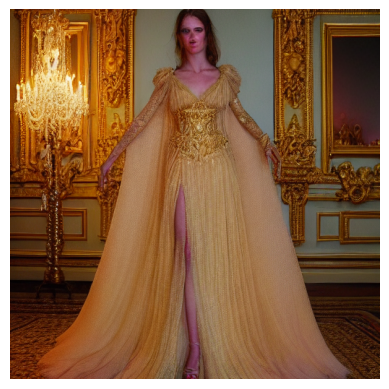

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt

model_path = '/kaggle/working/final_model'
pipe = StableDiffusionPipeline.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe.to(device)

prompt = "A mesmerizing sorceress dressed in an opulent Rococo-style gown, adorned with intricate golden embroidery and shimmering gemstones. Her voluminous powdered hair is styled with delicate pearls and enchanted flowers that glow softly in the dim candlelight. She stands in a grand, baroque palace, its towering gilded mirrors reflecting the ethereal glow of floating magical orbs. In her hand, she holds an ancient spellbook, its pages turning as if guided by an invisible force. Her piercing eyes radiate wisdom and power, and a soft magical aura envelops her, illuminating the lavish surroundings with an otherworldly glow. The air is filled with swirling golden dust, and faintly glowing sigils hover around her, pulsating with arcane energy. The atmosphere is rich in intricate details—silk drapes embroidered with celestial patterns, marble columns with carved cherubs, and enchanted candelabras that burn with a mesmerizing blue flame. The entire scene is captured with cinematic lighting, deep shadows, and soft, glowing highlights, evoking the grandeur of an 18th-century painting infused with fantasy magic."

with torch.no_grad():
    image = pipe(prompt).images[0]

plt.imshow(image)
plt.axis("off")
plt.show()

# image.save("generated_image.png")
